<h1>
    AutoEncoders
</h1>

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
n_inputs = 3 # 3D inputs
n_hidden = 2 # 2D codings

In [7]:
n_outputs = n_inputs

In [8]:
learning_rate = 0.01

In [3]:
tf.compat.v1.disable_eager_execution()

In [10]:
X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.keras.layers.Dense(n_hidden, activation=None)(X)
outputs = tf.keras.layers.Dense(n_outputs, activation=None)(hidden)

In [11]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) #MSE

In [12]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

In [13]:
init = tf.compat.v1.global_variables_initializer()

In [14]:
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [16]:
n_iterations = 1000
codings = hidden # output of the hidden layers provides the coding

In [17]:
with tf.compat.v1.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X:X_train}) # No labels, unsupervised
    coding_val = codings.eval(feed_dict={X: X_test})

2024-04-17 12:38:28.193688: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


In [27]:
import matplotlib
import matplotlib.pyplot as plt

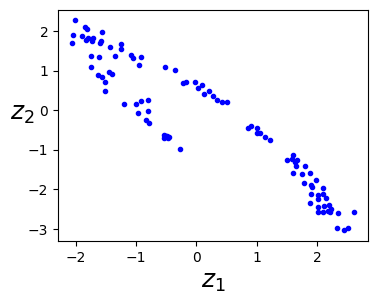

In [19]:
fig = plt.figure(figsize=(4,3))
plt.plot(coding_val[:,0], coding_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

<h3>
    Tensorflow Implementation
</h3>
<p>
    Implementing stacked autoencoder using MNIST Dataset
</p>

In [20]:
from functools import partial

In [21]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

In [22]:
learning_rate = 0.01
l2_reg = 0.001

In [23]:
X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])

In [24]:
he_init = tf.compat.v1.variance_scaling_initializer()
l2_regularizer = tf.keras.regularizers.l2(l2=l2_reg)

In [25]:
Dense_layer = partial(
    tf.keras.layers.Dense,
    activation = tf.nn.elu,
    kernel_initializer=he_init,
    kernel_regularizer=l2_regularizer)

In [26]:
hidden_1 = Dense_layer(n_hidden1)(X)
hidden_2 = Dense_layer(n_hidden2)(hidden_1)
hidden_3 = Dense_layer(n_hidden3)(hidden_2)
outputs = Dense_layer(n_outputs)(hidden_3)

In [27]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [28]:
reg_losses = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

In [29]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [30]:
init = tf.compat.v1.global_variables_initializer()

In [31]:
mnist = tf.keras.datasets.mnist.load_data(
    path='mnist.npz'
)

In [13]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [14]:
x_train = x_train.reshape(60000, 784)

In [15]:
x_test = x_test.reshape(10000, 784)

In [35]:
n_epochs = 5
batch_size = 150

In [36]:
saver = tf.compat.v1.train.Saver()
import sys

In [37]:
with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        num_iter = x_train.shape[0] // batch_size
        for iter in range(num_iter):
            x_batch = x_train[iter*batch_size:iter*batch_size+batch_size]
            sess.run(training_op, feed_dict={
                X: x_batch
            }
                    )
        #sess.run(training_op, feed_dict={X: x_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: x_test})   
        print("\r{}".format(epoch), "Train MSE:", loss_train)           
        saver.save(sess, "./autoencoder.ckpt")  

0 Train MSE: 1690.3676
1 Train MSE: 1470.2396
2 Train MSE: 1335.3442
3 Train MSE: 1338.1399
4 Train MSE: 1317.8533


In [38]:
X_exp = x_train

In [39]:
X_exp.shape

(60000, 784)

In [34]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [29]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.compat.v1.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = x_test[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./autoencoder.ckpt


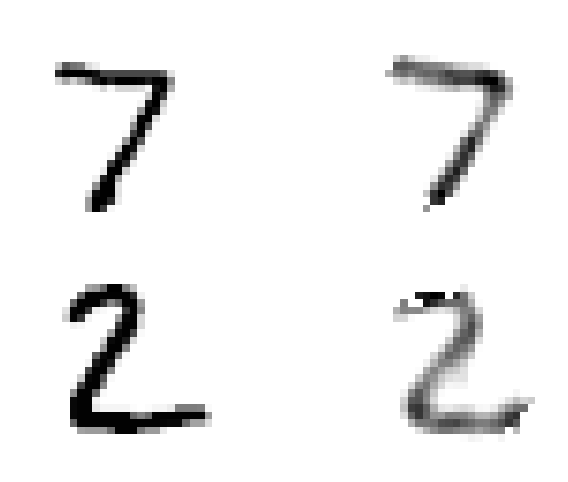

In [42]:
show_reconstructed_digits(X, outputs, "./autoencoder.ckpt")

<h3>
    Tying Weights
</h3>

In [4]:
def reset_graph(seed=42):
    tf.compat.v1.reset_default_graph()
    tf.compat.v1.set_random_seed(seed)
    np.random.seed(seed)
reset_graph()

In [85]:
activation = tf.nn.elu
regularizer = tf.keras.regularizers.L2(l2=l2_reg)
initializer = tf.compat.v1.variance_scaling_initializer()

In [86]:
X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])

In [87]:
weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

In [88]:
weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3") # Tied Weights
weights4 = tf.transpose(weights1, name="weights4") # Tied Weights

In [89]:
biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

In [90]:
hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

In [91]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

In [83]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)

In [69]:
training_op = optimizer.minimize(loss)

In [70]:
init = tf.compat.v1.global_variables_initializer()

In [71]:
n_epochs = 5
batch_size = 150

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches =  x_train.shape[0] // batch_size
        for iter in range(n_batches):
            print("\r{}%".format(100 * iter // n_batches), end="")
            sys.stdout.flush()
            X_batch = x_train[iter*batch_size:iter*batch_size+batch_size]
            sess.run(training_op, feed_dict={X: X_batch})
        #loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
    #saver.save(sess, "./autoencoder-weights-1.ckpt", meta_graph_suffix='meta', write_meta_graph=True)

0 Train MSE: 1317.8533
1 Train MSE: 1317.8533
2 Train MSE: 1317.8533
3 Train MSE: 1317.8533
4 Train MSE: 1317.8533



<h3>
    Training one Encoder at a time
</h3>
<p> In phases</p>

In [101]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.keras.regularizers.L2(l2=l2_reg)
initializer = tf.compat.v1.variance_scaling_initializer()

X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.compat.v1.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.compat.v1.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.compat.v1.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.compat.v1.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.compat.v1.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.compat.v1.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.compat.v1.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.compat.v1.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [102]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)

In [135]:
x_train = x_train / 255
x_test = x_test / 255

In [123]:
with tf.compat.v1.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

In [124]:
with tf.compat.v1.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars)

In [125]:
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [138]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [10, 10]
batch_sizes = [150, 150]

In [136]:
with tf.compat.v1.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = x_train.shape[0] // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch = x_train[iter*batch_size:iter*batch_size+batch_size]
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./autoencoder-3.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: x_test})
    print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.005492356
1 Train MSE: 0.005445854
2 Train MSE: 0.0055198227
39% Train MSE: 0.0054396763
4 Train MSE: 0.005361287
5 Train MSE: 0.0053151175
6 Train MSE: 0.005246514
7 Train MSE: 0.0053386544
8 Train MSE: 0.0051969723
9 Train MSE: 0.0052527916
10 Train MSE: 0.0051563485
11 Train MSE: 0.005327335
12% Train MSE: 0.0052120513
13 Train MSE: 0.005461655
14 Train MSE: 0.00550261
15 Train MSE: 0.03713632
16 Train MSE: 0.020270398
17 Train MSE: 0.014972296
18 Train MSE: 0.011872392
19 Train MSE: 0.009756763
Training phase #2
0 Train MSE: 0.64190376
1 Train MSE: 0.63822037
2 Train MSE: 0.6149025
3 Train MSE: 0.6148057
4 Train MSE: 0.67859703
5 Train MSE: 0.67851573
6 Train MSE: 0.67842335
7 Train MSE: 0.6783783
8 Train MSE: 0.6777977
9 Train MSE: 0.49137622
10 Train MSE: 0.17223345
11 Train MSE: 0.010305246
12 Train MSE: 0.004017827
13 Train MSE: 0.0017853425
14 Train MSE: 0.0066294093
15 Train MSE: 0.0024885184
16 Train MSE: 0.002605454
17 Train MSE: 0.003556724

<h3>
    Visualizing the reconstructions
</h3>

INFO:tensorflow:Restoring parameters from ./autoencoder-3.ckpt


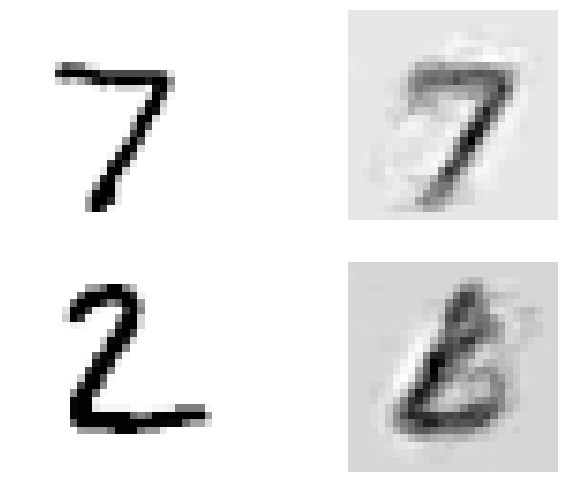

In [140]:
show_reconstructed_digits(X, outputs, "./autoencoder-3.ckpt")

<h3>
    Visualizing the features
</h3>

In [139]:
with tf.compat.v1.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = x_train.shape[0] // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch = x_train[iter*batch_size:iter*batch_size+batch_size]
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            weights1_val = weights1.eval()
            saver.save(sess, "./autoencoder-3.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: x_test})
    print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.005423838
1 Train MSE: 0.005441173
2 Train MSE: 0.0054396763
3 Train MSE: 0.0053097857
4 Train MSE: 0.00523209
5 Train MSE: 0.0053386544
6 Train MSE: 0.0052186977
7 Train MSE: 0.00518173
8 Train MSE: 0.005327335
9 Train MSE: 0.0052436474
Training phase #2
09% Train MSE: 0.0014963793
1 Train MSE: 0.0014345237
2 Train MSE: 0.0014239616
3 Train MSE: 0.001419429
4 Train MSE: 0.0014168337
5 Train MSE: 0.0014094303
6 Train MSE: 0.0014109913
7 Train MSE: 0.0013942405
8 Train MSE: 0.0013868703
9 Train MSE: 0.0013844004
Test MSE: 0.029621044


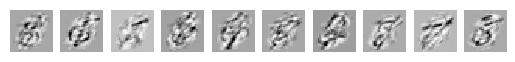

In [142]:
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plot_image(weights1_val.T[i])

<h3>
    Denoising Autoencoders
</h3>
<p>
    Tensorflow Implementation <br>
    Gaussial Noise
</p>

In [144]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [148]:
noise_level = 1.0

X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.compat.v1.random_normal(tf.shape(X))

hidden1 = tf.keras.layers.Dense(n_hidden1, activation=tf.nn.relu,
                          name="hidden1")(X_noisy)
hidden2 = tf.keras.layers.Dense(n_hidden2, activation=tf.nn.relu, 
                          name="hidden2")(hidden1)                       
hidden3 = tf.keras.layers.Dense(n_hidden3, activation=tf.nn.relu, 
                          name="hidden3")(hidden2)                          
outputs = tf.keras.layers.Dense(n_outputs, name="outputs")(hidden3)        

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) 

In [149]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [150]:
n_epochs = 10
batch_size = 150

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = x_train.shape[0] // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch = x_train[iter*batch_size:iter*batch_size+batch_size]
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./autoencoder_stacked_denoising_gaussian.ckpt")

0 Train MSE: 0.026577111
1 Train MSE: 0.023116248
2 Train MSE: 0.021808764
3 Train MSE: 0.020286942
4 Train MSE: 0.021523308
5 Train MSE: 0.020578576
6 Train MSE: 0.020649176
7 Train MSE: 0.019655138
8 Train MSE: 0.020133778
9 Train MSE: 0.019514265


INFO:tensorflow:Restoring parameters from ./autoencoder_stacked_denoising_gaussian.ckpt


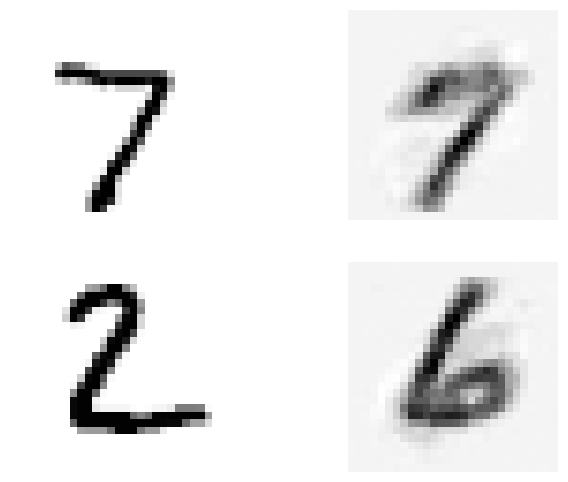

In [151]:
show_reconstructed_digits(X, outputs, "./autoencoder_stacked_denoising_gaussian.ckpt")

<h3>
    Denoising Autoencoders
</h3>
<p>
    Tensorflow Implementation <br>
    Dropout function
</p>

In [158]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [159]:
dropout_rate = 0.3
training = tf.compat.v1.placeholder_with_default(False, shape=(), name='training')

In [161]:
X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.keras.layers.Dropout(dropout_rate)(X)

hidden1 = tf.keras.layers.Dense(n_hidden1, activation=tf.nn.relu,
                          name="hidden1")(X_drop)
hidden2 = tf.keras.layers.Dense(n_hidden2, activation=tf.nn.relu, 
                          name="hidden2")(hidden1)                   
hidden3 = tf.keras.layers.Dense(n_hidden3, activation=tf.nn.relu, 
                          name="hidden3")(hidden2)                            
outputs = tf.keras.layers.Dense(n_outputs, name="outputs")(hidden3)       

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [162]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [163]:
n_epochs = 10
batch_size = 150

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = x_train.shape[0] // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch = x_train[iter*batch_size:iter*batch_size+batch_size]
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./autoencoder_stacked_denoising_dropout.ckpt")

0 Train MSE: 0.004028695
1 Train MSE: 0.002298606
2 Train MSE: 0.0018749778
3 Train MSE: 0.0018777306
4 Train MSE: 0.001622035
59% Train MSE: 0.0012945717
6 Train MSE: 0.0012689398
7 Train MSE: 0.0011115322
8 Train MSE: 0.0012996946
9 Train MSE: 0.0011504764


INFO:tensorflow:Restoring parameters from ./autoencoder_stacked_denoising_dropout.ckpt


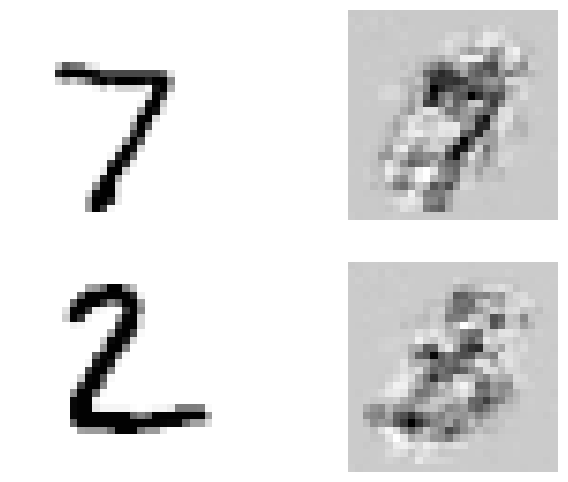

In [165]:
show_reconstructed_digits(X, outputs, "./autoencoder_stacked_denoising_dropout.ckpt")

<h3>
    Sparse Autoencoders
</h3>
<p>
    Using the Kulback - Leiber Divergence which has a stronger gradient that Mean - Squared Error
</p>

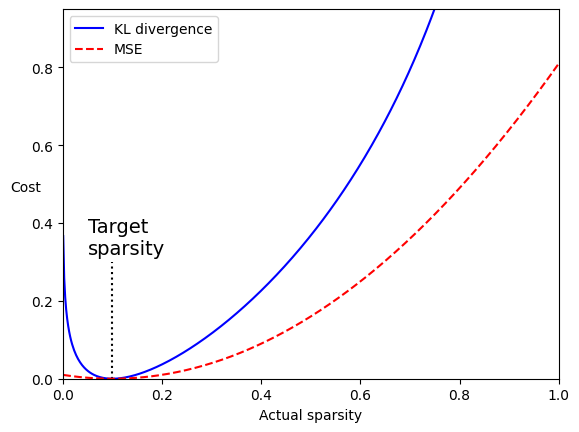

In [167]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.show()

In [206]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # sparse codings
n_outputs = n_inputs

In [207]:
def kl_divergence(p, q):
    return p * tf.compat.v1.log(p/q) + (1 - p) * tf.compat.v1.log((1 - p) / (1 - q))

In [208]:
learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

In [209]:
X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])            

hidden1 = tf.keras.layers.Dense(n_hidden1, activation=tf.compat.v1.nn.sigmoid)(X)
outputs = tf.keras.layers.Dense(n_outputs)(hidden1)             

In [210]:
hidden1_mean = tf.reduce_mean(hidden1, axis=0) 
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) 
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [211]:
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [212]:
n_epochs = 100
batch_size = 1000

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = x_train.shape[0] // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch = x_train[iter*batch_size:iter*batch_size+batch_size]
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./autoencoder_sparsity.ckpt")

0 Train MSE: nan 	Sparsity loss: nan 	Total loss: nan
1 Train MSE: nan 	Sparsity loss: nan 	Total loss: nan
2 Train MSE: nan 	Sparsity loss: nan 	Total loss: nan
3 Train MSE: nan 	Sparsity loss: nan 	Total loss: nan
4 Train MSE: nan 	Sparsity loss: nan 	Total loss: nan
5 Train MSE: nan 	Sparsity loss: nan 	Total loss: nan
6 Train MSE: nan 	Sparsity loss: nan 	Total loss: nan
7 Train MSE: nan 	Sparsity loss: nan 	Total loss: nan
8 Train MSE: nan 	Sparsity loss: nan 	Total loss: nan
9 Train MSE: nan 	Sparsity loss: nan 	Total loss: nan
10 Train MSE: nan 	Sparsity loss: nan 	Total loss: nan
11 Train MSE: nan 	Sparsity loss: nan 	Total loss: nan
12 Train MSE: nan 	Sparsity loss: nan 	Total loss: nan
13 Train MSE: nan 	Sparsity loss: nan 	Total loss: nan
14 Train MSE: nan 	Sparsity loss: nan 	Total loss: nan
15 Train MSE: nan 	Sparsity loss: nan 	Total loss: nan
16 Train MSE: nan 	Sparsity loss: nan 	Total loss: nan
17 Train MSE: nan 	Sparsity loss: nan 	Total loss: nan
18 Train MSE: nan 	S

INFO:tensorflow:Restoring parameters from ./autoencoder_sparsity.ckpt


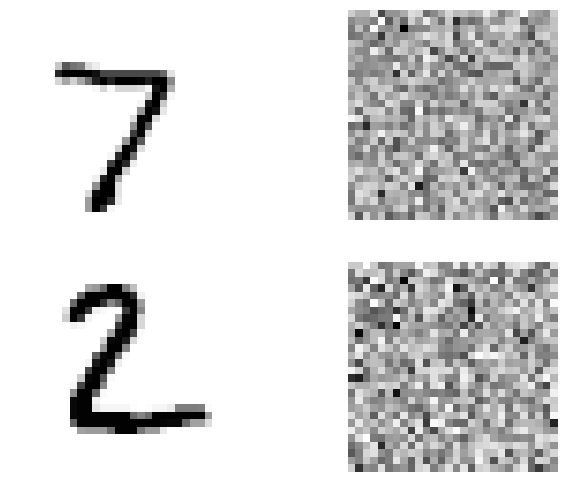

In [213]:
show_reconstructed_digits(X, outputs, "./autoencoder_sparsity.ckpt")

<h3>
    AutoEncoders
</h3>

In [214]:
reset_graph()

In [8]:
eps = 0.0000000001

In [9]:
from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.compat.v1.variance_scaling_initializer()

my_dense_layer = partial(
    tf.keras.layers.Dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.compat.v1.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(n_hidden1)(X)
hidden2 = my_dense_layer(n_hidden2)(hidden1)
hidden3_mean = my_dense_layer(n_hidden3, activation=None)(hidden2)
hidden3_sigma = my_dense_layer(n_hidden3, activation=None)(hidden2)
noise = tf.compat.v1.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(n_hidden4)(hidden3)
hidden5 = my_dense_layer(n_hidden5)(hidden4)
logits = my_dense_layer(n_outputs, activation=None)(hidden5)
outputs = tf.sigmoid(logits)

xentropy = tf.compat.v1.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

In [10]:
eps = 1e-10 
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.compat.v1.log(eps + tf.square(hidden3_sigma)))

In [17]:
loss = reconstruction_loss + latent_loss

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [16]:
x_train = x_train / 255
x_test = x_test / 255

In [224]:
n_epochs = 50
batch_size = 150

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = x_train.shape[0] // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch = x_train[iter*batch_size:iter*batch_size+batch_size]
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./variational_autoencoder.ckpt")

0 Train total loss: 24339.525 	Reconstruction loss: 17193.654 	Latent loss: 7145.8716
1 Train total loss: 16689.973 	Reconstruction loss: 11982.455 	Latent loss: 4707.5176
2 Train total loss: 18833.414 	Reconstruction loss: 13416.554 	Latent loss: 5416.86
3 Train total loss: 14626.069 	Reconstruction loss: 10117.3125 	Latent loss: 4508.757
4 Train total loss: 11220.121 	Reconstruction loss: 8332.217 	Latent loss: 2887.9048
5 Train total loss: 10437.251 	Reconstruction loss: 7946.009 	Latent loss: 2491.242
6 Train total loss: 10076.691 	Reconstruction loss: 7791.7734 	Latent loss: 2284.9177
7 Train total loss: 9857.266 	Reconstruction loss: 7673.995 	Latent loss: 2183.2708
8 Train total loss: 9672.844 	Reconstruction loss: 7678.05 	Latent loss: 1994.7944
9 Train total loss: 9575.523 	Reconstruction loss: 7653.066 	Latent loss: 1922.4578
10 Train total loss: 9420.159 	Reconstruction loss: 7503.4395 	Latent loss: 1916.7201
11 Train total loss: 9322.221 	Reconstruction loss: 7488.6426 	Lat

INFO:tensorflow:Restoring parameters from ./variational_autoencoder.ckpt


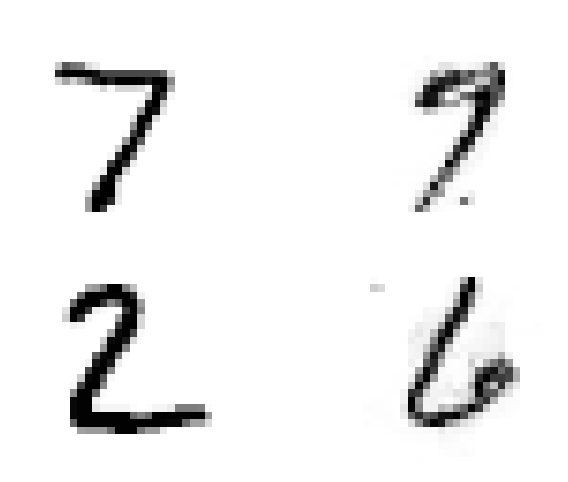

In [225]:
show_reconstructed_digits(X, outputs, "./variational_autoencoder.ckpt")

In [5]:
reset_graph()

<h3>
    Generating Digits
</h3>

In [22]:
import numpy
import sys

In [25]:
n_digits = 60
n_epochs = 10
batch_size = 150

In [26]:
with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = x_train.shape[0] // batch_size
        for iter in range(n_batches):
            print("\r{}%".format(100 * iter // n_batches), end="")
            X_batch = x_train[iter*batch_size:iter*batch_size+batch_size]
            sys.stdout.flush()
            sess.run(training_op, feed_dict={X: X_batch})
        coding_rnd = np.random.normal(size=[n_digits, n_hidden3])
        outputs_val = outputs.eval(feed_dict={hidden3: coding_rnd})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./variational_autoencoder.ckpt")

0 Train total loss: 26970.258 	Reconstruction loss: 21819.955 	Latent loss: 5150.302
1 Train total loss: 25211.334 	Reconstruction loss: 20780.361 	Latent loss: 4430.9727
2 Train total loss: 24829.508 	Reconstruction loss: 20139.018 	Latent loss: 4690.49
3 Train total loss: 29134.973 	Reconstruction loss: 20241.902 	Latent loss: 8893.071
4 Train total loss: 22968.412 	Reconstruction loss: 18749.086 	Latent loss: 4219.3257
5 Train total loss: 25279.188 	Reconstruction loss: 19949.062 	Latent loss: 5330.1245
6 Train total loss: 24307.04 	Reconstruction loss: 20276.594 	Latent loss: 4030.4446
7 Train total loss: 23205.361 	Reconstruction loss: 18547.129 	Latent loss: 4658.2324
8 Train total loss: 19620.832 	Reconstruction loss: 16167.004 	Latent loss: 3453.8281
9 Train total loss: 19693.049 	Reconstruction loss: 15633.055 	Latent loss: 4059.9934


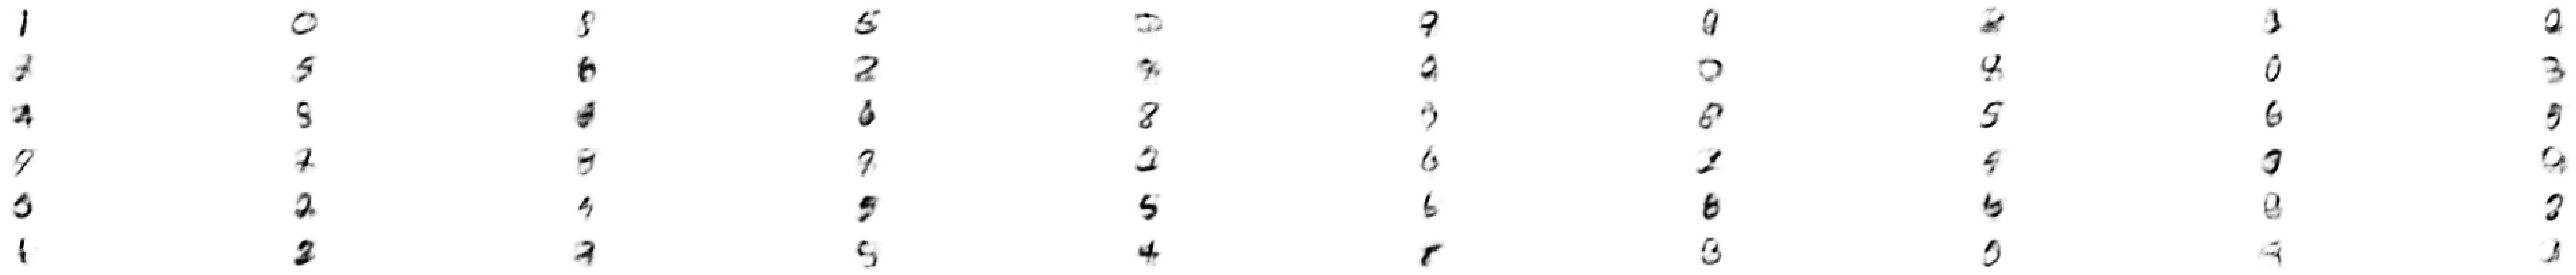

In [44]:
plt.figure(figsize=(100, 100))
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])